In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Dataset and Saving it as a Pandas DataFrame

In [5]:
bookReviewDataSet_filename = os.path.join(os.getcwd(), "bookReviews.csv")
df = pd.read_csv(bookReviewDataSet_filename, header=0)
df.head(5)

,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True


## Defining the ML Problem

I will be predicting if a given book review is positive or negative. The label is Positive Review. This is a supervised binary classification problem. Because this is a NLP, there is only one feature column, 'Review'. This problem is important because it reduces the need to manually read and analyze each review. This automation can help in many ways, but especially in getting quicker feedback about the book from the target audience and/or customers.

## Data Preparation

To prepare the data, I will check if there are any missing values. With this dataset and the defined problem, finding/replacing outliers, renaming features/labels, etc. do not apply. Instead, I will check for a class imbalance, and preprocess the data by transforming text into numerical features using word embeddings.

In [6]:
#check for any null values
df.isnull().values.any()

False

Text(0.5, 1.0, 'Barplot of Label Distribution Between Classes')

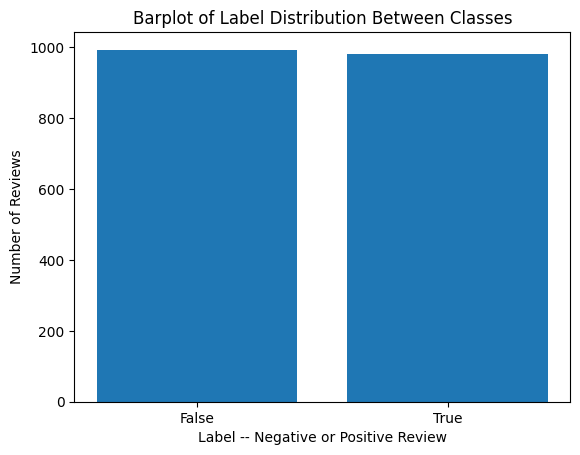

In [7]:
#check for class imbalance
x_axis=['False', 'True']
y_axis = df['Positive Review'].value_counts()
plt.bar(x_axis, y_axis)
plt.xlabel('Label -- Negative or Positive Review')
plt.ylabel('Number of Reviews')
plt.title('Barplot of Label Distribution Between Classes')

The classes are well balanced. The False label indicates a Negative review (it is false that the reveiw is Positive) and the True label indicates a Positive review.

This is a binary classification NLP ML problem, so there is only one feature column, 'Review'. To prepare the data, I will first split it into training and testing sets, and then transform the data to numerical features using word embeddings. The model I have chosen is a Logistic Regression. I will construct the model using the LogisticRegression model object from Scikit Learn. I will analyze and improve its performance by iteratively testing different values for hyperparameter c. I will then use the best value in the final model.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import time

In [9]:
# creating labeled examples
y = df['Positive Review']
X = df['Review']

print(y.shape)
print(X.shape)

(1973,)
(1973,)


### Preprocessing Text using Gensim

To transform the text data into numerical features, I will train the Word2Vec model using Gensim. I will preprocess the data using the Gensim simple_prepocess. This step removes stopwords, converts all words to lowercase, and splits the text into smaller segments.

In [10]:
import gensim

In [11]:
X_original = X
X = X.apply(lambda row: gensim.utils.simple_preprocess(row))

In [12]:
# creating testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1234)

X_train.head()

,Review
1369,"[as, my, brother, said, when, flipping, throug..."
1366,"[cooper, book, is, yet, another, warm, and, fu..."
385,"[have, many, robot, books, and, this, is, the,..."
750,"[as, china, re, emerges, as, dominant, power, ..."
643,"[have, been, huge, fan, of, michael, crichton,..."


In [13]:
# training the Word2Vec model using X_train
word2vec_model = gensim.models.Word2Vec(X_train, vector_size=100, window=4, min_count=2)

In [14]:
vocabulary_size = len(word2vec_model.wv.key_to_index) #size of vocabulary
print(vocabulary_size)

10354


In [15]:
# creating feature vectors
words = set(word2vec_model.wv.index_to_key)
#transforming X_train set
X_train_word_embeddings = np.array([np.array([word2vec_model.wv[word] for word in words if word in training_example])
                        for training_example in X_train], dtype=object)

#transforming X_test set
X_test_word_embeddings = np.array([np.array([word2vec_model.wv[word] for word in words if word in training_example])
                        for training_example in X_test], dtype=object)

In [16]:
# adjusting vectors so that there is a consistent number of features per example
X_train_feature_vector = []
for w in X_train_word_embeddings:
    if w.size:
        X_train_feature_vector.append(w.mean(axis=0))
    else:
        X_train_feature_vector.append(np.zeros(100, dtype=float))

X_test_feature_vector = []
for w in X_test_word_embeddings:
    if w.size:
        X_test_feature_vector.append(w.mean(axis=0))
    else:
        X_test_feature_vector.append(np.zeros(100, dtype=float))

## Fitting and Evaluating the Logistic Regression Model

The text data has been preprocessed and transformed into numerical features, so we can proceed to constructing the Logistic Regssion model.

In [17]:
# creating and fitting the model
def train_test_LR(X_train, y_train, X_test, y_test, c=1):
    # model object
    model = LogisticRegression(C=c)
    model.fit(X_train_feature_vector, y_train)

    # make predictions on transformed test data using predict_proba()
    probability_predictions = model.predict_proba(X_test_feature_vector)[:,1]

    # make predictions on transformed test data using predict()
    class_label_predictions = model.predict(X_test_feature_vector)

    # log loss
    l_loss = log_loss(y_test, probability_predictions)

    # accuracy
    acc_score = accuracy_score(y_test, class_label_predictions)
    print('Accuracy: ' + str(acc_score))

    return [l_loss, acc_score]

In [18]:
# evaluating the model using different hyperparameters
cs = [10**i for i in range(-10,10)]
for C in cs:
    result = train_test_LR(X_train, y_train, X_test, y_test, c=C)
    print('Log loss and accuracy scores for c: ' + str(C) + ', ' + str(result[1]) + ', ' + str(result[1]))

Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 1e-10, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 1e-09, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 1e-08, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 1e-07, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 1e-06, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 1e-05, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 0.0001, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.4962025316455696
Log loss and accuracy scores for c: 0.001, 0.4962025316455696, 0.4962025316455696
Accuracy: 0.579746835443038
Log loss and accuracy scores for c: 0.01, 0.579746835443038, 0.579746835443038
Accu

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6962025316455697
Log loss and accuracy scores for c: 10, 0.6962025316455697, 0.6962025316455697


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7063291139240506
Log loss and accuracy scores for c: 100, 0.7063291139240506, 0.7063291139240506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7215189873417721
Log loss and accuracy scores for c: 1000, 0.7215189873417721, 0.7215189873417721


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.6759493670886076
Log loss and accuracy scores for c: 10000, 0.6759493670886076, 0.6759493670886076
Accuracy: 0.7037974683544304
Log loss and accuracy scores for c: 100000, 0.7037974683544304, 0.7037974683544304


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7164556962025317
Log loss and accuracy scores for c: 1000000, 0.7164556962025317, 0.7164556962025317


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7139240506329114
Log loss and accuracy scores for c: 10000000, 0.7139240506329114, 0.7139240506329114


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7088607594936709
Log loss and accuracy scores for c: 100000000, 0.7088607594936709, 0.7088607594936709
Accuracy: 0.7189873417721518
Log loss and accuracy scores for c: 1000000000, 0.7189873417721518, 0.7189873417721518


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
# final model
# model object
model = LogisticRegression(C=10000000)
model.fit(X_train_feature_vector, y_train)

# make predictions on transformed test data using predict_proba()
probability_predictions = model.predict_proba(X_test_feature_vector)[:,1]

# make predictions on transformed test data using predict()
class_label_predictions = model.predict(X_test_feature_vector)

# log loss
l_loss = log_loss(y_test, probability_predictions)
print('Log loss: ' + str(l_loss))

# accuracy
acc_score = accuracy_score(y_test, class_label_predictions)
print('Accuracy: ' + str(acc_score))

Log loss: 0.5844592435560431
Accuracy: 0.7139240506329114


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now we can look at a review from the data set.

In [21]:
print('Review from example #100\n')
print(X_original[100])

print('\nPrediction: Is this review positive? {}\n'.format(class_label_predictions[100]))

print('Actual: Is this review positive? {}\n'.format(y_test.to_numpy()[100]))

Review from example #100

For those who endeavor to perfect fine art digital printmaking, this is the book to read.  It is a &quot;how to&quot; and so much more.  The book covers paper, ink, techniques, hand coloring and the practical application and intereaction of all of these variables.  The book is cogently written and elegantly displayed.  It is a must for anyone's library who wishes to expand their horizons in the digital printing arena.  Ms. Airey is a master of her craft and it shows


Prediction: Is this review positive? True

Actual: Is this review positive? True

